# Process for Creating an Image Classifier

# Import libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Upload Dataset

1. Upload *profile_images.zip* to the `/content` directory.
2. Run the cell below to unzip and remove.
3. Set directory for dataset and verify size.

In [ ]:
!unzip profile_images.zip
!rm profile_images.zip

In [ ]:
import pathlib

data_dir = pathlib.Path("/content/profile_images")
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)


307


# Set Up Dataset

Define some parameters for loading in the dataset.
Try changing batch_size to improve accuracy (original is 32).
Original image sizes are over 300x300. Size was set to 300x300 when loading
.

In [ ]:
batch_size = 32
img_height = 300
img_width = 300

Split the data 80-20 for training and validation.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 307 files belonging to 2 classes.
Using 246 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 307 files belonging to 2 classes.
Using 61 files for validation.


Check the class names of the dataset. They should respond to directory names.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['bots', 'people']


Run the next cell to view the first 9 images of the training set. This cell is OPTIONAL.

WARNING: The nature of some of the images are explicit! View at your own discretion!

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The next cell configures the dataset for performance.
Methods when loading data:

`Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Set Up the Model

The Sequential model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function ('relu'). 

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general input values should be small. Standardize values to be in the [0, 1] range by using `tf.keras.layers.Rescaling` for the first layer.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to `Model.compile`.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

View all the layers of the network using the model's `Model.summary` method:

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 150, 150, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 75, 75, 64)       

# Training the Model

The next section trains and saves a series of models to find one that performs well.



In [ ]:
%mkdir training_1 training_2 training_3 training_4 # Creates the directories for saving the models.

mkdir: cannot create directory ‘training_1’: File exists
mkdir: cannot create directory ‘training_2’: File exists
mkdir: cannot create directory ‘training_3’: File exists
mkdir: cannot create directory ‘training_4’: File exists


In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[cp_callback]
)

Epoch 1/15
8/8 [==============================] - ETA: 0s - loss: 1.8855 - accuracy: 0.5163
Epoch 1: saving model to training_1/cp.ckpt
8/8 [==============================] - 24s 3s/step - loss: 1.8855 - accuracy: 0.5163 - val_loss: 0.6945 - val_accuracy: 0.5410
Epoch 2/15
8/8 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.5772
Epoch 2: saving model to training_1/cp.ckpt
8/8 [==============================] - 21s 3s/step - loss: 0.6826 - accuracy: 0.5772 - val_loss: 0.7607 - val_accuracy: 0.4590
Epoch 3/15
8/8 [==============================] - ETA: 0s - loss: 0.7296 - accuracy: 0.5285
Epoch 3: saving model to training_1/cp.ckpt
8/8 [==============================] - 20s 3s/step - loss: 0.7296 - accuracy: 0.5285 - val_loss: 0.6894 - val_accuracy: 0.5082
Epoch 4/15
8/8 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.5732
Epoch 4: saving model to training_1/cp.ckpt
8/8 [==============================] - 21s 3s/step - loss: 0.6791 - accurac

Create plots of loss and accuracy on the training and validation sets:

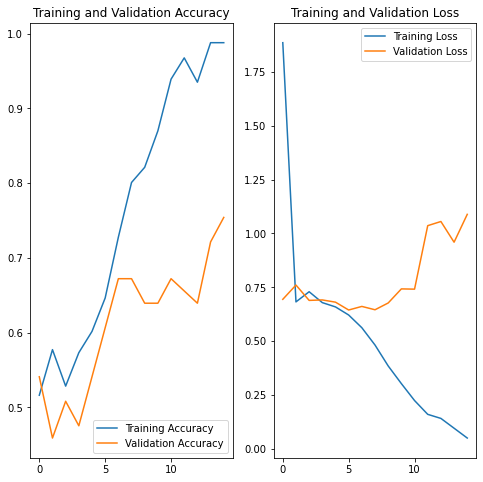

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Overfitting generally occurs if there is a small number of training images. We have 246 images which is pretty small. A solution is data augmentation, which generates additional training data from the existing set by augmenting them using random transformations that yield similar images.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
  ]
)

Another technique to reduce overfitting is to introduce dropout regularization to the network.

A dropout layer randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. The original value is 0.2, but this can be tweaked to better adjust the model.

The third model is a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images.

In [ ]:
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

epochs2 = 15
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs2,
  callbacks=[cp_callback]
)

Epoch 1/15
8/8 [==============================] - ETA: 0s - loss: 3.4392 - accuracy: 0.5000
Epoch 1: saving model to training_2/cp.ckpt
8/8 [==============================] - 26s 3s/step - loss: 3.4392 - accuracy: 0.5000 - val_loss: 0.7267 - val_accuracy: 0.5410
Epoch 2/15
8/8 [==============================] - ETA: 0s - loss: 0.7138 - accuracy: 0.4837
Epoch 2: saving model to training_2/cp.ckpt
8/8 [==============================] - 28s 3s/step - loss: 0.7138 - accuracy: 0.4837 - val_loss: 0.6958 - val_accuracy: 0.4590
Epoch 3/15
8/8 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.5528
Epoch 3: saving model to training_2/cp.ckpt
8/8 [==============================] - 23s 3s/step - loss: 0.6826 - accuracy: 0.5528 - val_loss: 0.6802 - val_accuracy: 0.5902
Epoch 4/15
8/8 [==============================] - ETA: 0s - loss: 0.6738 - accuracy: 0.5569
Epoch 4: saving model to training_2/cp.ckpt
8/8 [==============================] - 23s 3s/step - loss: 0.6738 - accurac

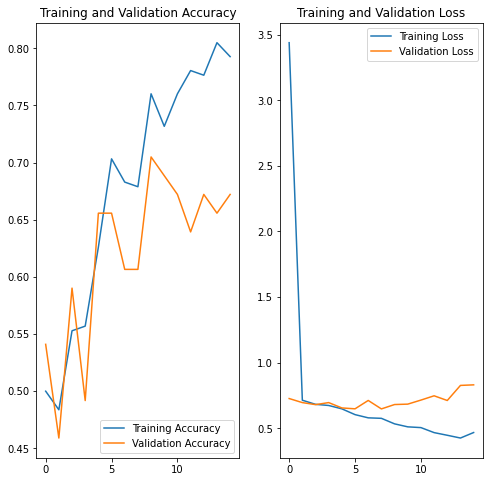

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Using the Trained Model

In [ ]:
img_path = '/content/headshot.png'

img = tf.keras.utils.load_img(
    img_path, target_size=(300, 300)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

result = class_names[np.argmax(score)]


This image most likely belongs to people with a 62.96 percent confidence.
people
